In [1]:
import bw2data as bd
from collections import defaultdict
from tqdm import tqdm
from thefuzz import fuzz

In [2]:
bd.projects.set_current('GSA for archetypes')

In [3]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.8 cutoff
	swiss consumption 1.0

The inspiration for these virtual markets was the input of 'soybean' to 'market for soybean, feed' which has a reference product 'soybean, feed'. We can't just test exact matching, need to be a bit [more flexible](https://github.com/seatgeek/thefuzz) on these virtual markets.

In [4]:
def similar(a, b):
    return fuzz.partial_ratio(a, b) > 90 or fuzz.ratio(a, b) > 40

In [5]:
def find_uncertain_virtual_markets(database):
    db = bd.Database(database)

    found = {}
    
    for act in tqdm(db):
        rp = act.get("reference product")
        if not rp:
            continue
            
        inpts = defaultdict(list)
        for exc in act.technosphere():
            if exc.input == exc.output:
                continue
            elif exc['uncertainty type'] < 2:
                continue
            inpts[exc.input['reference product']].append(exc)
            
        for key, lst in inpts.items():
            if len(lst) > 1 and similar(rp, key) and 0.98 <= sum([exc['amount'] for exc in lst]) <= 1.02:
                found[act] = lst
            
    return found

In [ ]:
found = find_uncertain_virtual_markets("ecoinvent 3.8 cutoff")

 58%|███████████████████████████████████████████▊                               | 11424/19565 [03:50<02:53, 46.89it/s]

In [6]:
len(found)

61

In [7]:
ng = list(found)[5]
ng, found[ng]

('natural gas, high pressure, import from NL' (cubic meter, PL, None),
 [Exchange: 0.2840284 cubic meter 'petroleum and gas production, off-shore' (cubic meter, NL, None) to 'natural gas, high pressure, import from NL' (cubic meter, PL, None)>,
  Exchange: 0.7160716 cubic meter 'petroleum and gas production, on-shore' (cubic meter, NL, None) to 'natural gas, high pressure, import from NL' (cubic meter, PL, None)>])

In [ ]:
found

We can use the [dirichlet](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html) to model parameters with a fixed sum, but this distribution is sensitive to the concentration values.

In [8]:
from scipy.stats import dirichlet
import numpy as np
import seaborn as sb

In [59]:
x = np.array([exc['amount'] for exc in found[ng]])
alpha = x.copy()

dirichlet.mean(alpha)

array([0.284, 0.716])

In [60]:
rvs = dirichlet.rvs(alpha, size=1000)

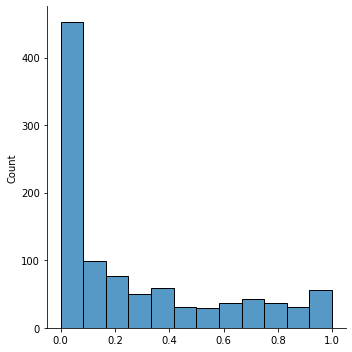

In [61]:
sb.displot(rvs[:, 0])

In [62]:
rvs = dirichlet.rvs(alpha * 10, size=1000)

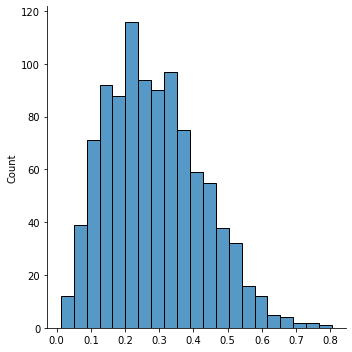

In [63]:
sb.displot(rvs[:, 0])

In [64]:
rvs = dirichlet.rvs(alpha * 500, size=1000)

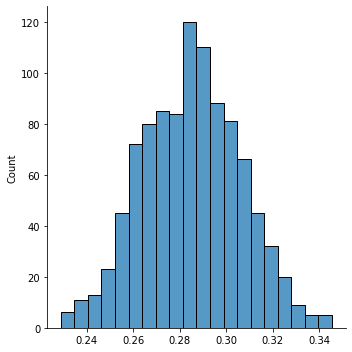

In [65]:
sb.displot(rvs[:, 0])

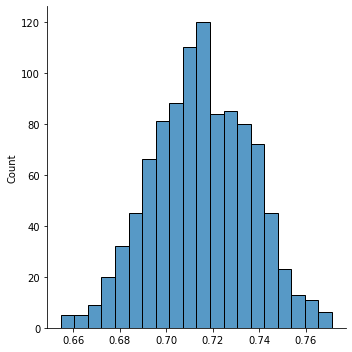

In [66]:
sb.displot(rvs[:, 1])

We can use these new values in Monte Carlo assessment (in place of the independent sampling which results in broken mass balances). The exact approach here will probably be different; for example, one could use trade statistics to create regional markets with much higher precision.

The underlying concepts in the following are documented in [bw_processing](https://github.com/brightway-lca/bw_processing) and [matrix_utils](https://github.com/brightway-lca/matrix_utils). In this notebook we will use in-memory datapackages for our fixes.

In [16]:
import bw_processing as bwp

In [17]:
indices_array = np.array([(exc.input.id, exc.output.id) for exc in found[ng]], dtype=bwp.INDICES_DTYPE)

# Redefine alpha to make sure order is consistent
# Transpose to get rows or exchange indices, columns of possible values
data_array = dirichlet.rvs(np.array([exc['amount'] for exc in found[ng]]) * 500, size=1000).T

# technosphere inputs must be flipped
flip_array = np.ones(len(found[ng]), dtype=bool)

In [18]:
dp = bwp.create_datapackage()

In [19]:
dp.add_persistent_array(
    matrix="technosphere_matrix",
    data_array=data_array,
    name="ng-fix-dz-es",
    indices_array=indices_array,
    flip_array=flip_array,
)

Compare Monte Carlo results with and without the fix

In [20]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

In [21]:
_, data_objs, _ = bd.prepare_lca_inputs({ng: 1}, method=ipcc)

Default is to use three datapackages: biosphere database, ecoinvent database, and LCIA method

In [22]:
data_objs

In [23]:
import bw2calc as bc

In [47]:
lca = bc.LCA({ng.id: 1}, data_objs=data_objs, use_distributions=True)
lca.lci()
lca.lcia()

In [48]:
unmodified = np.array([lca.score for _ in zip(lca, range(250))])

In [49]:
fixed = bc.LCA({ng.id: 1}, data_objs=data_objs + [dp], use_arrays=True, use_distributions=True)
fixed.lci()
fixed.lcia()

In [50]:
modified = np.array([fixed.score for _ in zip(fixed, range(250))])

Uncertainty for this example is not huge, so difference is not obvious

In [51]:
np.mean(modified), np.std(modified), np.mean(unmodified), np.std(modified)

(0.07180383251106659,
 0.014339692216107132,
 0.07214504176627519,
 0.014339692216107132)

In [52]:
for exc in found[ng]:
    lca.redo_lcia({exc.input.id: 1})
    print(lca.score)

0.06735432695017118
0.03625739048224403


In [53]:
for exc in found[ng]:
    print(exc['scale'])

0.16155494421403513
0.16155494421403513


In [54]:
sum([
    lca.technosphere_matrix[lca.dicts.product[row], lca.dicts.activity[col]]
    for row, col in indices_array
])

-0.8414860872087331

In [55]:
sum([
    fixed.technosphere_matrix[fixed.dicts.product[row], fixed.dicts.activity[col]]
    for row, col in indices_array
])

-0.9999999999999998

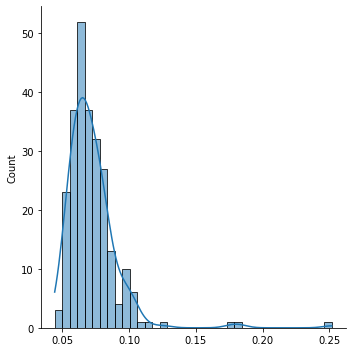

In [56]:
sb.displot(unmodified, kde=True)

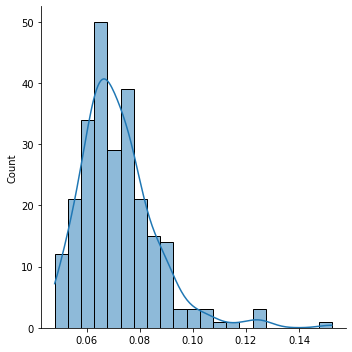

In [57]:
sb.displot(modified, kde=True)

# 